<a href="https://colab.research.google.com/github/IsraelMarqs/Predicao_de_Evasao_com_Regressao_Logistica/blob/main/Predi%C3%A7%C3%A3o_de_Evas%C3%A3o_com_Regress%C3%A3o_Log%C3%ADstica.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Preparando Ambiente

In [ ]:
!pip install fastapi uvicorn pyngrok pydantic scikit-learn pandas joblib

In [8]:
!ngrok config add-authtoken 2oJ1IdQm0weSKuZ5KXZBT7Iblzn_2TFismSZtXUDjEFuuX7Sb

Authtoken saved to configuration file: /root/.config/ngrok/ngrok.yml



# Modelo

Acurácia no Treino: 80.73%
Acurácia no Teste:  80.68%
------------------------------

Relatório do Teste:
              precision    recall  f1-score   support

           0       0.63      0.42      0.50      6989
           1       0.84      0.92      0.88     23011

    accuracy                           0.81     30000
   macro avg       0.73      0.67      0.69     30000
weighted avg       0.79      0.81      0.79     30000



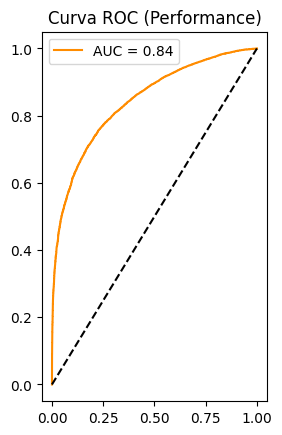

['logistic_model.pkl']

In [9]:
import pandas as pd
import numpy as np
import seaborn as sns
import joblib
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, roc_curve, roc_auc_score

# 1. CONFIGURAÇÃO
np.random.seed(100)

# 2. GERAÇÃO DE DADOS
n_samples = 100000

data = {
    'idade': np.random.randint(17, 35, n_samples),
    'nota_enem': np.random.normal(600, 100, n_samples),
    'horas_trabalho_semana': np.random.choice([0, 20, 30, 40], n_samples),
    'reprovacoes_1_sem': np.random.choice([0, 0, 1, 2, 3], n_samples),
    'distancia_campus_km': np.random.exponential(15, n_samples),
    'bolsista': np.random.choice([0, 1], n_samples, p=[0.6, 0.4]),
    'trabalha': np.random.choice([0, 1], n_samples)
}
df = pd.DataFrame(data)

ruido = np.random.normal(0, 1.2, n_samples)

score_risco = (
    - ((df['nota_enem'] - 600) / 100) * 0.6       # Nota influencia moderadamente
    + (df['reprovacoes_1_sem']) * 0.9             # Reprovação influencia muito
    + (df['horas_trabalho_semana'] / 40) * 0.4    # Trabalho influencia pouco
    + ruido                                       # FATOR CAOS/HUMANO
)

# Sigmoid para transformar em probabilidade
probabilidade = 1 / (1 + np.exp(-score_risco))
df['evasao_ate_1ano'] = (probabilidade > 0.5).astype(int)

# 3. TREINAMENTO
X = df.drop('evasao_ate_1ano', axis=1)
y = df['evasao_ate_1ano']

# Separação
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

# 4. DIAGNÓSTICO DE OVERFITTING
acc_train = accuracy_score(y_train, model.predict(X_train))
acc_test = accuracy_score(y_test, model.predict(X_test))

print(f"Acurácia no Treino: {acc_train:.2%}")
print(f"Acurácia no Teste:  {acc_test:.2%}")
print("-" * 30)

# 5. GRÁFICOS E REPORT
print("\nRelatório do Teste:")
print(classification_report(y_test, model.predict(X_test)))

# Curva ROC
proba_test = model.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, proba_test)
auc = roc_auc_score(y_test, proba_test)

plt.subplot(1, 2, 2)
plt.plot(fpr, tpr, label=f"AUC = {auc:.2f}", color='darkorange')
plt.plot([0, 1], [0, 1], 'k--')
plt.title("Curva ROC (Performance)")
plt.legend()
plt.show()

# Salvar
joblib.dump(model, 'logistic_model.pkl')

# Preparação para API

In [ ]:
from pyngrok import ngrok
import uvicorn
import threading

# Função para rodar o servidor uvicorn em uma thread separada
def run_server():
    uvicorn.run("app.main:app", port=8000, host="0.0.0.0")

# Inicia o servidor em background
t = threading.Thread(target=run_server)
t.start()

# Abre o túnel para a porta 8000
public_url = ngrok.connect(8000).public_url
print(f"🚀 API rodando! Acesse a documentação em: {public_url}/docs")

# Arquivos MVC

In [13]:
import os
# Criando a árvore de diretórios
os.makedirs("app/models", exist_ok=True)
os.makedirs("app/schemas", exist_ok=True)
os.makedirs("app/controllers", exist_ok=True)
os.makedirs("app/views", exist_ok=True)
os.makedirs("app/services", exist_ok=True)
os.makedirs("app/core", exist_ok=True)

In [14]:
%%writefile app/schemas/prediction_schema.py
from pydantic import BaseModel

class StudentInput(BaseModel):
    idade: int
    nota_enem: float
    horas_trabalho_semana: int
    reprovacoes_1_sem: int
    distancia_campus_km: float
    bolsista: int
    trabalha: int

class PredictionOutput(BaseModel):
    prob_evasao: float
    classe_prevista: int

Writing app/schemas/prediction_schema.py


In [15]:
%%writefile app/services/ml_service.py
import joblib
import pandas as pd
import os

class MLService:
    def __init__(self):
        # Carrega o modelo que geramos na Parte 1
        self.model = joblib.load('logistic_model.pkl')

    def predict_proba(self, data: dict) -> float:
        # Transforma o dict em DataFrame (o sklearn espera array/df)
        df = pd.DataFrame([data])
        # Retorna a probabilidade da classe 1 (evasão)
        return self.model.predict_proba(df)[0][1]

ml_service = MLService()

Writing app/services/ml_service.py


In [16]:
%%writefile app/controllers/prediction_controller.py
from app.services.ml_service import ml_service
from app.schemas.prediction_schema import StudentInput, PredictionOutput

class PredictionController:
    def predict(self, student_data: StudentInput):
        # Converte o input do Pydantic para dict
        data_dict = student_data.dict()

        # Chama o serviço de ML
        probability = ml_service.predict_proba(data_dict)

        # Aplica o threshold de 0.5 [cite: 167]
        classe = 1 if probability >= 0.5 else 0

        return PredictionOutput(
            prob_evasao=round(probability, 4),
            classe_prevista=classe
        )

prediction_controller = PredictionController()

Writing app/controllers/prediction_controller.py


In [17]:
%%writefile app/views/prediction_view.py
from fastapi import APIRouter, HTTPException
from app.schemas.prediction_schema import StudentInput, PredictionOutput
from app.controllers.prediction_controller import prediction_controller

router = APIRouter()

@router.post("/predict", response_model=PredictionOutput)
def predict_evasion(student: StudentInput):
    try:
        return prediction_controller.predict(student)
    except Exception as e:
        raise HTTPException(status_code=500, detail=str(e))

@router.get("/health")
def health_check():
    return {"status": "ok", "model_loaded": True}

Writing app/views/prediction_view.py


In [18]:
%%writefile app/main.py
from fastapi import FastAPI
from app.views import prediction_view

app = FastAPI(title="API de Predição de Evasão")

# Registra as rotas
app.include_router(prediction_view.router)

Writing app/main.py
